In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
offers = pd.read_csv('data_offers.csv')
offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [4]:
orders = pd.read_csv('data_orders.csv')
orders.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
df = pd.merge(offers, orders, on='order_gk')

In [6]:
df.isna().sum()

order_gk                             0
offer_id                             0
order_datetime                       0
origin_longitude                     0
origin_latitude                      0
m_order_eta                      22904
order_status_key                     0
is_driver_assigned_key               0
cancellations_time_in_seconds     9473
dtype: int64

In [7]:
# Assigning values to the keys in dataset
df['is_driver_assigned'] = df['is_driver_assigned_key'].apply(lambda x: 'Driver_Assigned' if x > 0 else 'Driver_not_Assigned')
df['Order Status'] = df['order_status_key'].apply(lambda x: 'Cancelled_by_Client' if x == 4 else 'cancelled_by_System')

In [8]:
df.head(5)

,order_gk,offer_id,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_driver_assigned,Order Status
0,3000629332007,300052226205,17:53:21,-1.001639,51.492854,NaN,9,0,NaN,Driver_not_Assigned,cancelled_by_System
1,3000630355741,300052290999,07:01:42,-0.978128,51.454907,NaN,4,0,206.0,Driver_not_Assigned,Cancelled_by_Client
2,3000630756829,300052316583,22:56:24,-0.975385,51.456508,358.0,4,1,685.0,Driver_Assigned,Cancelled_by_Client
3,3000624867683,300051947884,13:06:52,-0.979216,51.463477,NaN,9,0,NaN,Driver_not_Assigned,cancelled_by_System
4,3000625767002,300052003160,22:58:34,-0.987531,51.452510,NaN,9,0,NaN,Driver_not_Assigned,cancelled_by_System


# Task1

##### Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

<Axes: title={'center': 'Orders according to reasons for failure'}, xlabel='Order Status', ylabel='is_driver_assigned'>

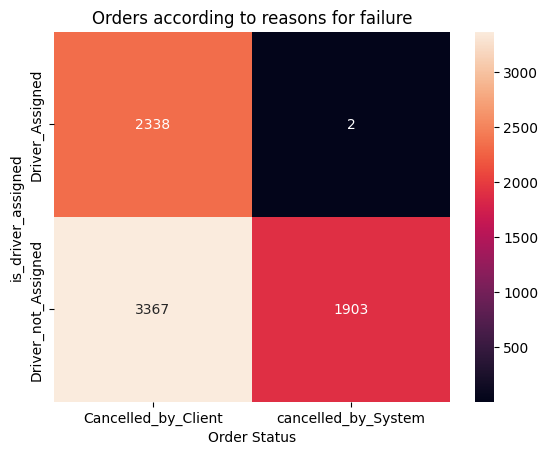

In [9]:
pivot = df.pivot_table(index = 'is_driver_assigned', columns = 'Order Status', values = 'order_gk', aggfunc = lambda x: len(x.unique()))

plt.title('Orders according to reasons for failure')
sns.heatmap(pivot, annot=True, fmt="d")

In [10]:
# Most of the cacelletions occur when Driver is not assigned and is cancelled by the client. 
# Other following buckets are driver assigned-cancelled by client & driver not assigned-cancelled by system. 
# There are 2 orders where driver was assigned but it got cancelled by system, deeper RCA is required to figure out these orders.

# Task 2

##### Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [11]:
df['order_datetime'] = pd.to_datetime(df['order_datetime']);
df['Order Hour'] = df['order_datetime'].dt.hour

C:\Users\singhk3\AppData\Local\Temp\ipykernel_97472\243455941.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['order_datetime'] = pd.to_datetime(df['order_datetime']);


In [12]:
pivot_hour = df.pivot_table(index='Order Hour', values='order_gk', aggfunc= lambda x: len(x.unique()))

<Axes: title={'center': 'Cancelled orders by hour'}, xlabel='Hour of day', ylabel='Count of cancelled orders'>

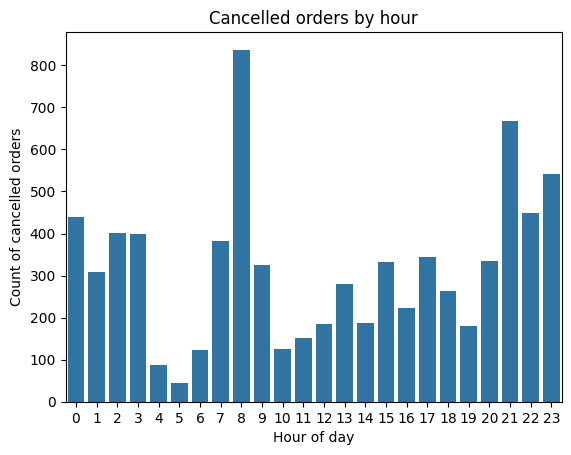

In [13]:
plt.title('Cancelled orders by hour')
plt.xlabel('Hour of day')
plt.ylabel('Count of cancelled orders')

sns.barplot(pivot_hour, x = 'Order Hour', y = 'order_gk')

In [14]:
# Most of the orders get cancelled from 8 to 9 in the morning. Second most problematic area for cancelled orders is late at night from 21-23 (9-11 PM). Least amount of orders get cancelled from 4 to 6 in the morning.
# 8 to 9 AM order cancels can be explained by the office rush and people booking cabs from multiple apps and riding with whichever came first.


# Task 3

##### Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [15]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['cancellations_time_in_seconds'].quantile(0.25)
Q3 = df['cancellations_time_in_seconds'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df['cancellations_time_in_seconds'] >= lower_bound) & (df['cancellations_time_in_seconds'] <= upper_bound)]

In [16]:
pivot_avg_hour = df_cleaned.pivot_table(index='Order Hour', columns= 'is_driver_assigned', values= 'cancellations_time_in_seconds', aggfunc= 'mean')

In [17]:
pivot_avg_hour

is_driver_assigned,Driver_Assigned,Driver_not_Assigned
Order Hour,,
0,153.654618,109.836842
1,138.146018,100.593997
2,155.353933,113.272569
3,136.527559,123.376344
4,137.921053,100.733333
5,106.024390,102.838710
6,107.717391,130.324675
7,125.667391,132.218504
8,120.315951,125.530441


<Axes: title={'center': 'Cancelled orders by hour and Driver Status'}, xlabel='Hour of day', ylabel='Average time of cancelled orders'>

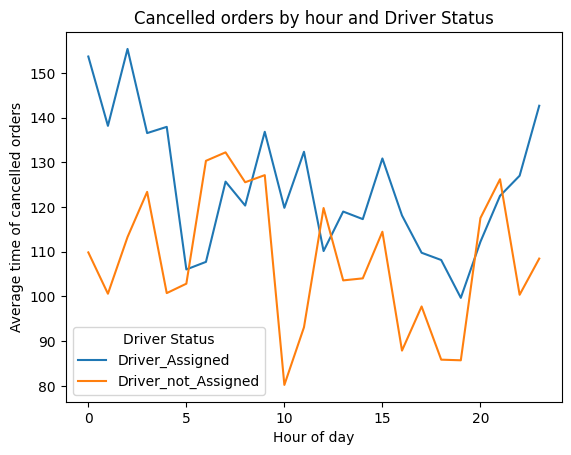

In [18]:
plt.title('Cancelled orders by hour and Driver Status')
plt.xlabel('Hour of day')
plt.ylabel('Average time of cancelled orders')

pivot_avg_hour.reset_index(inplace=True)
pivot_avg_hour_melted = pivot_avg_hour.melt(id_vars='Order Hour', value_vars=['Driver_Assigned', 'Driver_not_Assigned'], var_name='Driver Status', value_name='Average')

sns.lineplot(data=pivot_avg_hour_melted, x='Order Hour', y='Average', hue='Driver Status')

In [ ]:
# Cancellation time consistent across day
# Cancellations time due to Driver-not-assigned increases during peak hours
# Apart from peak hours, cancellation time is higher when driver is assinged.

# Task4

#### Plot the distribution of average ETA by hours. How can this plot be explained?

<Axes: title={'center': 'Average ETA by hour of day'}, xlabel=' Hour of day', ylabel='Average ETA'>

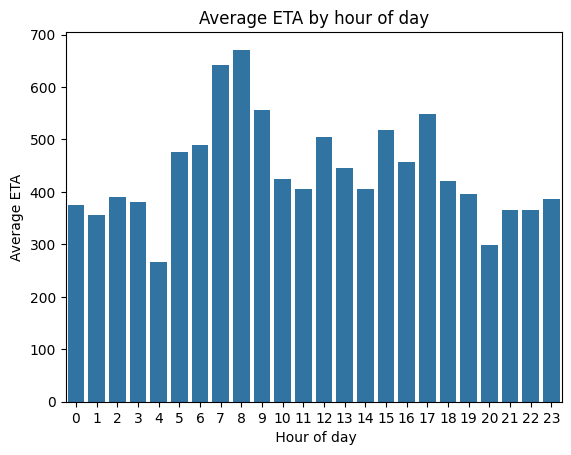

In [19]:
pivot_avg_hour_perday = df.pivot_table(index='Order Hour', values='m_order_eta', aggfunc= 'mean')

plt.title('Average ETA by hour of day')
plt.xlabel(' Hour of day')
plt.ylabel('Average ETA')

sns.barplot(data= pivot_avg_hour_perday, x = 'Order Hour', y = 'm_order_eta')

In [28]:
# Observations:
# Peak Hours: Higher average ETAs are observed during peak hours (e.g., morning rush hours and evening).
# Off-Peak Hours: Lower average ETAs are observed during off-peak hours (e.g., late night and early morning).

# Explanation:
# Traffic Conditions: During peak hours, increased traffic can lead to longer travel times, resulting in higher ETAs.
# Order Volume: Higher order volumes during peak hours can also contribute to longer wait times and higher ETAs.
# Driver Availability: During off-peak hours, there may be less traffic and more available drivers, leading to shorter ETAs.